# Notebook to visualise/analyse model predictions

In [73]:
import sys
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
sys.path.append(os.path.dirname(os.path.abspath('.')))

from dev.utils import load_wandb_model

model, cfg, train_loader, val_loader, test_loader, topo_data, metadata = load_wandb_model('5tcmz363', name='last.ckpt', device='cuda')

/mnt/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml-gnn/lib/python3.10/site-packages/tsl/datasets/metr_la.py:98: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(df.index[0], df.index[-1], freq='5T')
/mnt/cephfs/store/gr-mc2473/lc865/misc/condaforge/envs/ml-gnn/lib/python3.10/site-packages/tsl/datasets/metr_la.py:109: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df = df.replace(to_replace=0., method='ffill')


Predicted raw dataset size: 1.36 GB
Predicted raw dataset size: 1.36 GB

Dataloaders and Topology Data Overview:
Batch size: 16
----------------------------------------------------------
Name                 | Samples      | Batches     
----------------------------------------------------------
Train Loader         | 23973        | 1498        
Val Loader           | 3424         | 214         
Test Loader          | 6849         | 428         

Topology Data:
Number of nodes: 207
Number of edges: 1515
----------------------------------------------------------
Imported model from run "5tcmz363".
  | Name                | Type              | Params
----------------------------------------------------------
0 | criterion           | L1Loss            | 0     
1 | input_encoder_patch | Linear            | 256   
2 | input_encoder_node  | Linear            | 128   
3 | edge_encoder        | Linear            | 256   
4 | gnns                | ModuleList        | 99.6 K
5 | U              

In [75]:
# Initialize lists to store predictions and ground truth
all_preds = []
all_true = []

# Disable gradient computation for inference
with torch.no_grad():
    for x, y, mask_x, mask_y in tqdm(test_loader):
        # Get predictions
        y_hat = model(x.to(model.device))
        
        # Unnormalize predictions and ground truth
        y_hat = y_hat * metadata['norm_std'] + metadata['norm_mean'] 
        y = y * metadata['norm_std'] + metadata['norm_mean']
        
        # Store predictions and ground truth
        all_preds.append(y_hat.cpu())
        all_true.append(y.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0)
all_true = torch.cat(all_true, dim=0)

print(f"Predictions shape: {all_preds.shape}")
print(f"Ground truth shape: {all_true.shape}")


  0%|          | 0/428 [00:00<?, ?it/s]

100%|██████████| 428/428 [00:16<00:00, 25.71it/s]


Predictions shape: torch.Size([6848, 207, 12])
Ground truth shape: torch.Size([6848, 207, 12])


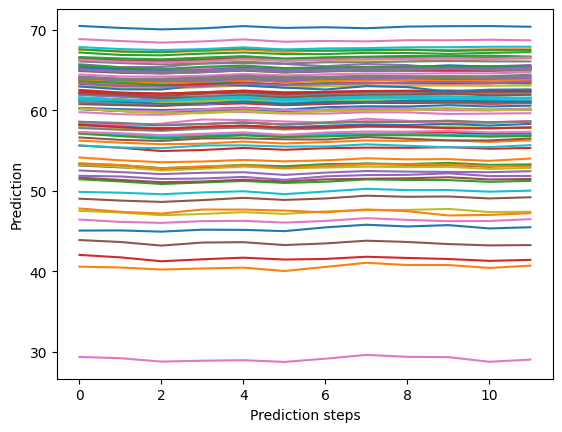

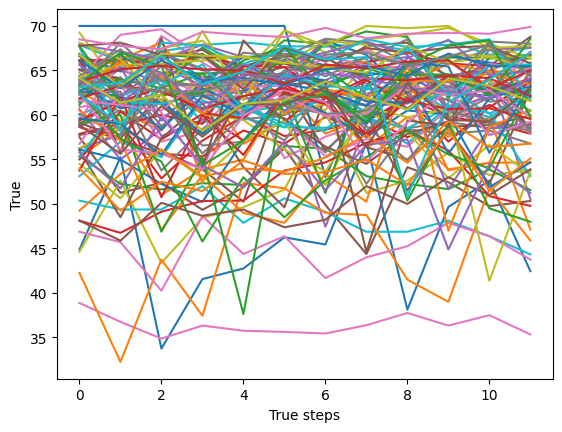

In [76]:
plt.plot(all_preds[0, :100, :].detach().numpy().T)
plt.xlabel('Prediction steps')
plt.ylabel('Prediction')
plt.show()

plt.plot(all_true[0, :100, :].detach().numpy().T)
plt.xlabel('True steps')
plt.ylabel('True')
plt.show()

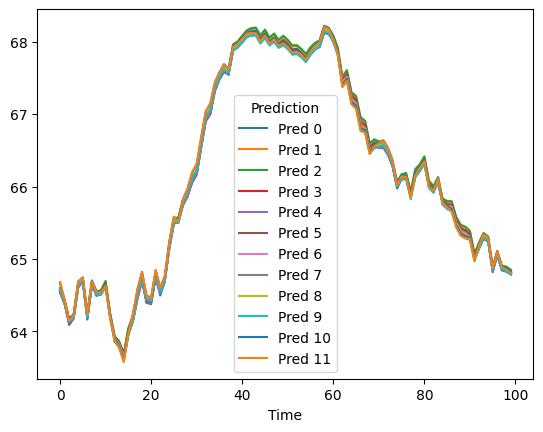

In [60]:
total_steps = 100
plt.plot(all_preds[:total_steps, 0, :].detach().numpy(), label=[f'Pred {i}' for i in range(all_preds.shape[2])])
plt.xlabel('Time')
plt.legend(title='Prediction')

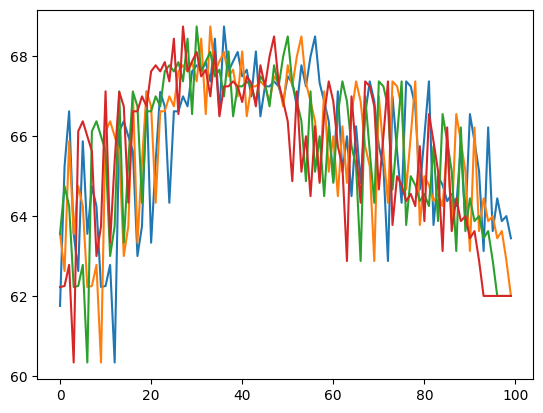

In [49]:

plt.plot(all_true[:total_steps, 0, ::3].detach().numpy(), label='True')

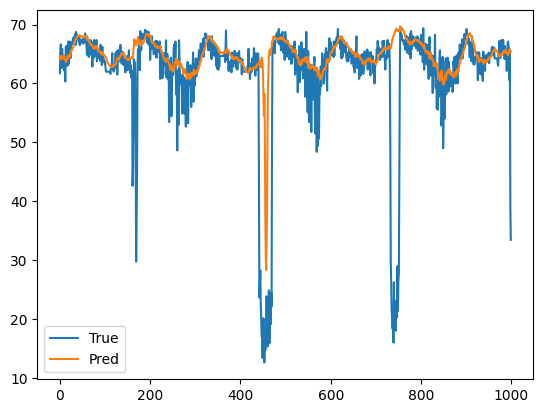

In [62]:
from matplotlib import pyplot as plt

horizon_steps = 0
total_steps = 1000

plt.plot(all_true[:total_steps, 0, horizon_steps].detach().numpy().T, label='True')
plt.plot(all_preds[:total_steps, 0, horizon_steps].detach().numpy().T, label='Pred')
plt.legend()
plt.show()

In [29]:
pred = model(batch[0].to(device))
true = batch[1].to(device)

pred = pred * metadata['norm_std'] + metadata['norm_mean']
true = true * metadata['norm_std'] + metadata['norm_mean']

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)

In [15]:
true.shape

torch.Size([16, 207, 12])

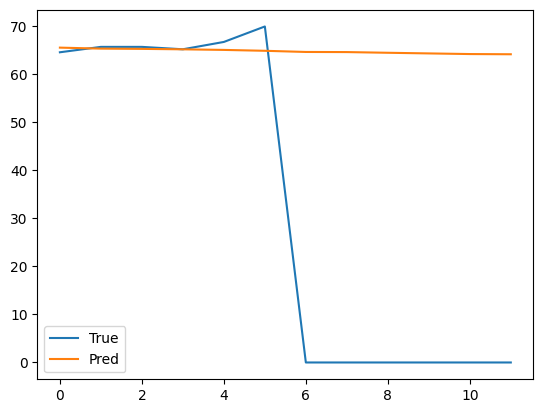

In [22]:
from matplotlib import pyplot as plt

plt.plot(true[0, 0, :].cpu().detach().numpy().T, label='True')
plt.plot(pred[0, 0, :].cpu().detach().numpy().T, label='Pred')
plt.legend()
plt.show()
